# Introduction

The following notebook presents both the definition of the models to be used (including preprocessing and hyperparameter tuning) and their respective evaluation.

# 0. Import Libraries and Other Code

In [1]:
# Relevant Libraries

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline , FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score

import seaborn as sns
import matplotlib.pyplot as plt

import os

# 1. Load and Split Dataset

In [2]:
# Loading dataset

PlantGrowth_Dataset = pd.read_csv("../Datasets/plant_growth_data.csv")

# Splitting variables into Numerical and Categorical Features and Target

labels_variables = PlantGrowth_Dataset.columns

Features = labels_variables[:-1]
Target = labels_variables[-1]

NumericalFeatures , CategoricalFeatures = [] , []
for feature in Features:
    if PlantGrowth_Dataset[feature].dtype == 'object':
        CategoricalFeatures.append(feature)
    else:
        NumericalFeatures.append(feature)

In [3]:
# Splitting dataset

RANDOM_STATE = 8013

X_train , X_test , y_train , y_test = train_test_split(PlantGrowth_Dataset[Features],PlantGrowth_Dataset[Target],test_size=0.25,random_state=RANDOM_STATE)

# 2. Preprocessing Pipeline

As it could be observed in the EDA of the dataset, the numerical features are not separated or distinguished according to the significant growth reported, therefore it is proposed to generate features that are obtained from them in a simple way, that is, by applying non-linear functions such as: ``sqrt``, ``log10``, ``1/x`` and ``x**2``, together with the identity function. In order to promote other types of interactions or relationships.

In the case of the categorical features, since the only relevant feature is ``Fertilizer_Type`` and the other two seem to be independent for predicting the type of growth, they are kept in case of possible interactions with the other numerical features.

In [ ]:
# Importing additional estimators

from sklearn.preprocessing import OneHotEncoder , StandardScaler , FunctionTransformer

In [ ]:
# Defining Numerical Preprocessing

extras_numerical_features = FeatureUnion(
    [
        ('x',FunctionTransformer(lambda x: x)),
        ('1/x',FunctionTransformer(lambda x: 1/x)),
        ('x**2',FunctionTransformer(lambda x: x*x)),
        ('sqrt',FunctionTransformer(np.sqrt)),
        ('log10',FunctionTransformer(np.log10)),
    ]
)

numerical_preprocessing = Pipeline(
    [
        ('ExtraFeatures',extras_numerical_features),
        ('Standardization',StandardScaler()),
    ]
)

numerical_preprocessing

Pipeline(steps=[('ExtraFeatures',
                 FeatureUnion(transformer_list=[('x',
                                                 FunctionTransformer(func=<function <lambda> at 0x00000297E6C58A40>)),
                                                ('1/x',
                                                 FunctionTransformer(func=<function <lambda> at 0x00000297E6C58720>)),
                                                ('x**2',
                                                 FunctionTransformer(func=<function <lambda> at 0x00000297E6C591C0>)),
                                                ('sqrt',
                                                 FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                ('log10',
                                                 FunctionTransformer(func=<ufunc 'log10'>))])),
                ('Standardization', StandardScaler())])

In [13]:
# Defining Categorical Preprocessing

categorical_preprocessing = Pipeline(
    [
        ('Encode',OneHotEncoder()),
    ]
)

In [16]:
# Defining Features Preprocessing

Features_Preprocessing = ColumnTransformer(
    [
        ('CategoricalFeatures',categorical_preprocessing,CategoricalFeatures),
        ('NumericalFeatures',numerical_preprocessing,NumericalFeatures),
    ]
)

Features_Preprocessing

ColumnTransformer(transformers=[('CategoricalFeatures',
                                 Pipeline(steps=[('Encode', OneHotEncoder())]),
                                 ['Soil_Type', 'Water_Frequency',
                                  'Fertilizer_Type']),
                                ('NumericalFeatures',
                                 Pipeline(steps=[('ExtraFeatures',
                                                  FeatureUnion(transformer_list=[('x',
                                                                                  FunctionTransformer(func=<function <lambda> at 0x00000297E6C58A40>)),
                                                                                 ('1/x',
                                                                                  FunctionTransformer(func=<function <lambda> at 0x00000297E6C58720>)),
                                                                                 ('x**2',
                                                                                  FunctionTransformer(func=<function <lambda> at 0x00000297E6C591C0>)),
                                                                                 ('sqrt',
                                                                                  FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                 ('log10',
                                                                                  FunctionTransformer(func=<ufunc 'log10'>))])),
                                                 ('Standardization',
                                                  StandardScaler())]),
                                 ['Sunlight_Hours', 'Temperature',
                                  'Humidity'])])

# Model Architectures

In [97]:
# Importing models

from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [98]:
# Model Architectures 

Model_Architectures = ['Forest','KNN','AdaBoost','Logistic','SVM']

# Defining number of threads or n_jobs 

THREADS = int(np.sqrt(os.cpu_count()))

## Random Forest

In [99]:
# Random Forest model

Model_Forest = Pipeline(
    [
        ('Preprocessing',Features_Preprocessing),
        ('Classifier',RandomForestClassifier(random_state=RANDOM_STATE,n_jobs=THREADS)),
    ]
)

Parameters_Forest = {
    'Classifier__n_estimators' : [25,50,75,100],
    'Classifier__criterion' : ['gini','entropy']
}

Model_Forest

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('CategoricalFeatures',
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder())]),
                                                  ['Soil_Type',
                                                   'Water_Frequency',
                                                   'Fertilizer_Type']),
                                                 ('NumericalFeatures',
                                                  Pipeline(steps=[('ExtraFeatures',
                                                                   FeatureUnion(transformer_list=[('x',
                                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000297E6C58A40>)),
                                                                                                  ('1/x',
                                                                                                   Fun...0000297E6C58720>)),
                                                                                                  ('x**2',
                                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000297E6C591C0>)),
                                                                                                  ('sqrt',
                                                                                                   FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                  ('log10',
                                                                                                   FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                  ('Standardization',
                                                                   StandardScaler())]),
                                                  ['Sunlight_Hours',
                                                   'Temperature',
                                                   'Humidity'])])),
                ('Classifier',
                 RandomForestClassifier(n_jobs=4, random_state=8013))])

## K-Nearest Neighbors

In [100]:
# KNN model

Model_KNN = Pipeline(
    [
        ('Preprocessing',Features_Preprocessing),
        ('Classifier',KNeighborsClassifier(n_jobs=THREADS)),
    ]
)

Parameters_KNN = {
    'Classifier__n_neighbors' : range(2,11),
    'Classifier__weights' : ['distance','uniform'],
}

Model_KNN

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('CategoricalFeatures',
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder())]),
                                                  ['Soil_Type',
                                                   'Water_Frequency',
                                                   'Fertilizer_Type']),
                                                 ('NumericalFeatures',
                                                  Pipeline(steps=[('ExtraFeatures',
                                                                   FeatureUnion(transformer_list=[('x',
                                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000297E6C58A40>)),
                                                                                                  ('1/x',
                                                                                                   Fun...unction <lambda> at 0x00000297E6C58720>)),
                                                                                                  ('x**2',
                                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000297E6C591C0>)),
                                                                                                  ('sqrt',
                                                                                                   FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                  ('log10',
                                                                                                   FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                  ('Standardization',
                                                                   StandardScaler())]),
                                                  ['Sunlight_Hours',
                                                   'Temperature',
                                                   'Humidity'])])),
                ('Classifier', KNeighborsClassifier(n_jobs=4))])

## Adaptive Boosting

In [101]:
# AdaBoost model

Model_AdaBoost = Pipeline(
    [
        ('Preprocessing',Features_Preprocessing),
        ('Classifier',AdaBoostClassifier(random_state=RANDOM_STATE,algorithm='SAMME')),
    ]
)

Parameters_AdaBoost = {
    'Classifier__n_estimators' : [25,50,75,100]
}

Model_AdaBoost

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('CategoricalFeatures',
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder())]),
                                                  ['Soil_Type',
                                                   'Water_Frequency',
                                                   'Fertilizer_Type']),
                                                 ('NumericalFeatures',
                                                  Pipeline(steps=[('ExtraFeatures',
                                                                   FeatureUnion(transformer_list=[('x',
                                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000297E6C58A40>)),
                                                                                                  ('1/x',
                                                                                                   Fun...97E6C58720>)),
                                                                                                  ('x**2',
                                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000297E6C591C0>)),
                                                                                                  ('sqrt',
                                                                                                   FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                  ('log10',
                                                                                                   FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                  ('Standardization',
                                                                   StandardScaler())]),
                                                  ['Sunlight_Hours',
                                                   'Temperature',
                                                   'Humidity'])])),
                ('Classifier',
                 AdaBoostClassifier(algorithm='SAMME', random_state=8013))])

## Logistic Regression

In [102]:
# Logistic regression model

Model_Logistic = Pipeline(
    [
        ('Preprocessing',Features_Preprocessing),
        ('Classifier',LogisticRegression(random_state=RANDOM_STATE,n_jobs=THREADS))
    ]
)

Parameters_Logistic = {
    'Classifier__C' : np.linspace(0.5,1.5,11)
}

Model_Logistic

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('CategoricalFeatures',
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder())]),
                                                  ['Soil_Type',
                                                   'Water_Frequency',
                                                   'Fertilizer_Type']),
                                                 ('NumericalFeatures',
                                                  Pipeline(steps=[('ExtraFeatures',
                                                                   FeatureUnion(transformer_list=[('x',
                                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000297E6C58A40>)),
                                                                                                  ('1/x',
                                                                                                   Fun...t 0x00000297E6C58720>)),
                                                                                                  ('x**2',
                                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000297E6C591C0>)),
                                                                                                  ('sqrt',
                                                                                                   FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                  ('log10',
                                                                                                   FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                  ('Standardization',
                                                                   StandardScaler())]),
                                                  ['Sunlight_Hours',
                                                   'Temperature',
                                                   'Humidity'])])),
                ('Classifier',
                 LogisticRegression(n_jobs=4, random_state=8013))])

## Support Vector Machine

In [103]:
# SVM model

Model_SVM = Pipeline(
    [
        ('Preprocessing',Features_Preprocessing),
        ('Classifier',SVC(random_state=RANDOM_STATE)),
    ]
)

Parameters_SVM = {
    'Classifier__C' : np.linspace(0.5,1.5,11)
}

Model_SVM

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('CategoricalFeatures',
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder())]),
                                                  ['Soil_Type',
                                                   'Water_Frequency',
                                                   'Fertilizer_Type']),
                                                 ('NumericalFeatures',
                                                  Pipeline(steps=[('ExtraFeatures',
                                                                   FeatureUnion(transformer_list=[('x',
                                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000297E6C58A40>)),
                                                                                                  ('1/x',
                                                                                                   Fun...(func=<function <lambda> at 0x00000297E6C58720>)),
                                                                                                  ('x**2',
                                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000297E6C591C0>)),
                                                                                                  ('sqrt',
                                                                                                   FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                  ('log10',
                                                                                                   FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                  ('Standardization',
                                                                   StandardScaler())]),
                                                  ['Sunlight_Hours',
                                                   'Temperature',
                                                   'Humidity'])])),
                ('Classifier', SVC(random_state=8013))])

# Models Fine-Tunning

In [104]:
# Global variables
Global_Variables = globals()

In [105]:
# Fine-Tunning using Cross-Validation

for model_name in Model_Architectures:
    estimator_model = Global_Variables[f'Model_{model_name}']
    parameters_model = Global_Variables[f'Parameters_{model_name}']

    Global_Variables[f'Best_{model_name}'] = GridSearchCV(estimator_model,parameters_model,scoring='f1',cv=4,n_jobs=THREADS)
    Global_Variables[f'Best_{model_name}'].fit(X_train,y_train)

C:\Users\alexi\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [185]:
# Printing of best parameters for each model

for model_name in Model_Architectures:
    best_parameters = Global_Variables[f'Best_{model_name}'].best_params_
    print(f'Best found parameters of {model_name} are:\n{best_parameters}\n')

Best found parameters of Forest are:
{'Classifier__criterion': 'gini', 'Classifier__n_estimators': 75}

Best found parameters of KNN are:
{'Classifier__n_neighbors': 8, 'Classifier__weights': 'distance'}

Best found parameters of AdaBoost are:
{'Classifier__n_estimators': 25}

Best found parameters of Logistic are:
{'Classifier__C': np.float64(0.5)}

Best found parameters of SVM are:
{'Classifier__C': np.float64(1.5)}



# Models Evaluation

In [174]:
# Evaluating models

Metrics = [accuracy_score,precision_score,recall_score,f1_score]
evaluation_results = {}

for model_name in Model_Architectures:
    y_predictions = Global_Variables[f'Best_{model_name}'].predict(X_test)
    evaluation_results[f'{model_name}'] = [metric(y_test,y_predictions) for metric in Metrics]

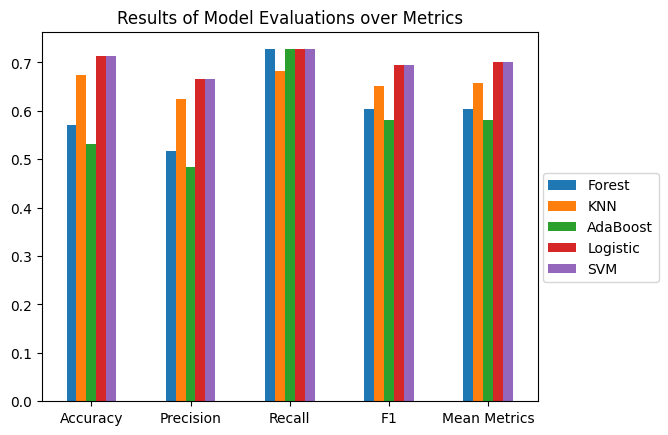

In [175]:
# Plotting results by metric

EvaluationsResults = pd.DataFrame(evaluation_results)
EvaluationsResults.loc[4] = EvaluationsResults.mean()
EvaluationsResults.rename(index={0:'Accuracy',1:'Precision',2:'Recall',3:'F1',4:'Mean Metrics'},inplace=True)

fig , axes = plt.subplots()
axes.set_title('Results of Model Evaluations over Metrics')
EvaluationsResults.plot(kind='bar',rot=0,ax=axes,legend=False)
fig.legend(bbox_to_anchor=(1.1,0.6));